## Exercise 2.5 問題:
(programming) Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q*( a) start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the q*( a) on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and longer runs, say of 10,000 steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 非定常なバンディット問題の生成
class NonStationaryBanditProblem:
    # k_armsは行動の種類数. 報酬はガウス分布からのサンプルだが, その分散を変えたいときはreward_varを変更する.
    def __init__(self, k_arms, reward_var=1):
        self.k_arms = k_arms
        self._true_qs = np.zeros(k_arms) # 各アクションの真の期待値. 最初は全て0からスタート
        self._reward_std = np.sqrt(reward_var)
        
    # kは取った行動のインデックス.
    def try_an_arm(self, k):
        true_q = self._true_qs[k]
        # 毎ステップ状態は変化していく(平均0, 標準偏差0.01のガウス分布が全てのアクションの期待値に加算される)
        self._true_qs += np.random.normal(0, 0.01, self.k_arms)
        return np.random.normal(true_q, self._reward_std) # 実際の報酬はガウス分布からのサンプル
    
    # 最適行動を取得. 問題を解くときは参照しない
    def _get_optimal_action(self):
        return np.argmax(self._true_qs)

In [3]:
# 多椀バンディット問題を解くためのϵ-greedyアルゴリズム
# problemは扱う問題, epsilonはε-greedyのε, n_stepsは1trialのステップ数, step_sizeは学習率
# step_sizeはデフォルトで-1で、この状態だと自動的に(1/ステップ数)を用いる. これはサンプル平均に相当（つまり, 報酬和を割引しない）
# 逆に, step_sizeが定数のときは(1-その値)が割引率になっている割引報酬和を使っていることに相当（多分）
# 戻り値は予想した各アクションの期待値（行動価値）, 選択した行動の系列, 各ステップ時点までの平均報酬
def epsilon_greedy(problem, epsilon, n_steps, step_size=-1):
    k_arms = problem.k_arms
    pred_qs = np.zeros(k_arms)
    selected_actions = np.zeros(n_steps)
    cumulative_reward = 0
    average_reward = np.zeros(n_steps)
    
    for step in range(n_steps):
        greedy = np.random.rand() >= epsilon
        if greedy:
            # 行動価値が等しい行動が複数あるときは, その中からランダムで選ぶ
            greedy_actions = np.arange(k_arms)[pred_qs == np.max(pred_qs)]
            action = np.random.choice(greedy_actions)
        else:
            # 完全にランダムに選ぶ
            action = np.random.randint(k_arms)
        
        reward = problem.try_an_arm(action)
        if step_size == -1:
            alpha = 1 / (step+1)
        else:
            alpha = step_size
        # 本文の言葉を借りれば'incremental implementation'. 分かりにくいが, step_size=-1のときはちゃんとサンプル平均にもなっている
        pred_qs[action] += alpha * (reward - pred_qs[action])
        
        # 後々最適行動の選択割合を計算するので選択した行動の系列を記録
        selected_actions[step] = action
        
        cumulative_reward += reward
        # そのステップ時点までの平均報酬を計算しておく
        average_reward[step] = cumulative_reward / (step+1)
    
    return pred_qs, selected_actions, average_reward

In [4]:
# 選択した行動の系列から各ステップ時点までの最適な行動を選択した割合を計算する
def calculate_optimal_action_rate(action_sequence, optimal_action):
    n_steps = len(action_sequence)
    optimal_action_rates = np.zeros(n_steps)
    is_optimal_action = (action_sequence == optimal_action)
    for step in range(n_steps):
        # そのステップ時点までの最適な行動の選択率を計算
        optimal_action_rates[step] = np.mean(is_optimal_action[:step+1])
    return optimal_action_rates

In [5]:
# バンディット問題を生成し, 実際に解く
# 戻り値は最適な行動の選択率（％）と平均報酬（どちらも, 各ステップ時点までのそれらの値をステップ数個並べたnp.array）
# config次第で非常に時間がかかるので注意
def solve_bandit_problem(problem_config, trial_config):
    k_arms = problem_config['k_arms']
    reward_var = problem_config['reward_var']
    
    n_runs = trial_config['n_runs']
    epsilon = trial_config['epsilon']
    n_steps = trial_config['n_steps']
    step_size = trial_config['step_size']
    
    optimal_action_rate_average_over_run = np.zeros(n_steps)
    average_reward_average_over_run = np.zeros(n_steps)
    for _ in tqdm(range(n_runs)):
        problem = NonStationaryBanditProblem(k_arms, reward_var)
        pred_qs, selected_actions, average_reward = epsilon_greedy(problem, epsilon, n_steps, step_size)
        optimal_action_rate = calculate_optimal_action_rate(selected_actions, problem._get_optimal_action())
    
        optimal_action_rate_average_over_run += optimal_action_rate
        average_reward_average_over_run += average_reward
    
    optimal_action_rate_average_over_run /= n_runs
    average_reward_average_over_run /= n_runs
    return optimal_action_rate_average_over_run*100, average_reward_average_over_run

### サンプル平均の実験

In [6]:
optimal_action_rate_sa = {}
average_reward_sa = {}
# epsilonは0(greedy), 0.01, 0.1を試す
for e in [0, 0.01, 0.1]:
    PROBLEM_CONFIG = {
        'k_arms': 10,
        'reward_var': 1
    }

    TRIAL_CONFIG = {
        'n_runs': 20, # 2000回も試行してられないので減らした
        'epsilon': e,
        'n_steps': 50000, # 10000stepじゃあまり収束しなかったので増やした
        'step_size': -1 # step_size=-1でサンプル平均を報酬の計算に使う
    }
    temp_optimal_action_rate, temp_average_reward = solve_bandit_problem(PROBLEM_CONFIG, TRIAL_CONFIG)
    optimal_action_rate_sa['epsilon_{}'.format(e)] = temp_optimal_action_rate
    average_reward_sa['epsilon_{}'.format(e)] = temp_average_reward

100%|████| 20/20 [01:12<00:00,  3.63s/it]


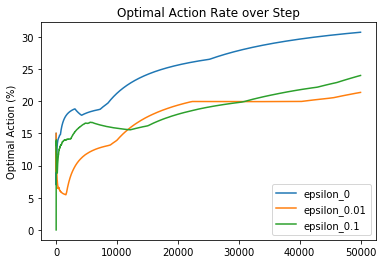

In [7]:
# サンプル平均の実験内で, epsilonを変えての比較
plt.title('Optimal Action Rate over Step')
plt.ylabel('Steps')
plt.ylabel('Optimal Action (%)')
for e in optimal_action_rate_sa:
    plt.plot(optimal_action_rate_sa[e], label=e)
plt.legend()
plt.show()

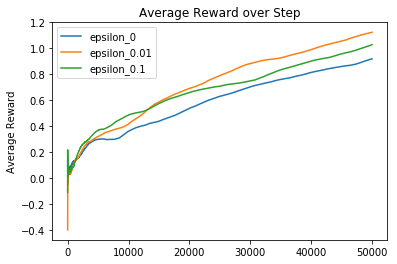

In [8]:
# サンプル平均の実験内で, epsilonを変えての比較
plt.title('Average Reward over Step')
plt.ylabel('Steps')
plt.ylabel('Average Reward')
for e in average_reward_sa:
    plt.plot(average_reward_sa[e], label=e)
plt.legend()
plt.show()

### 定数のステップサイズの実験

In [9]:
optimal_action_rate_cs = {}
average_reward_cs = {}
# epsilonは0(greedy), 0.01, 0.1を試す
for e in [0, 0.01, 0.1]:
    PROBLEM_CONFIG = {
        'k_arms': 10,
        'reward_var': 1
    }

    TRIAL_CONFIG = {
        'n_runs': 20,
        'epsilon': e,
        'n_steps': 50000,
        'step_size': 0.1 # step_sizeは問題文に従い0.1(他も試したが, 不安定になったり収束が遅くなったりあまり良いことはなかった)
    }
    temp_optimal_action_rate, temp_average_reward = solve_bandit_problem(PROBLEM_CONFIG, TRIAL_CONFIG)
    optimal_action_rate_cs['epsilon_{}'.format(e)] = temp_optimal_action_rate
    average_reward_cs['epsilon_{}'.format(e)] = temp_average_reward

100%|████| 20/20 [01:19<00:00,  3.96s/it]


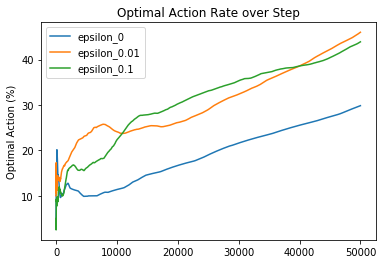

In [10]:
# 定数のステップサイズの中で, epsilonを変えての実験
plt.title('Optimal Action Rate over Step')
plt.ylabel('Steps')
plt.ylabel('Optimal Action (%)')
for e in optimal_action_rate_cs:
    plt.plot(optimal_action_rate_cs[e], label=e)
plt.legend()
plt.show()

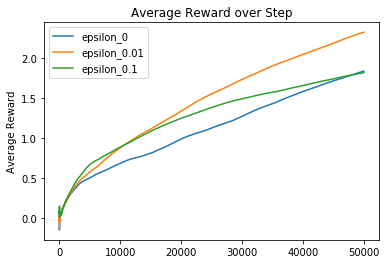

In [11]:
# 定数のステップサイズの中で, epsilonを変えての実験
plt.title('Average Reward over Step')
plt.ylabel('Steps')
plt.ylabel('Average Reward')
for e in average_reward_cs:
    plt.plot(average_reward_cs[e], label=e)
plt.legend()
plt.show()

### 2つの方法（サンプル平均と定数ステップサイズ, つまり割引なしの報酬平均と割引報酬和）の比較

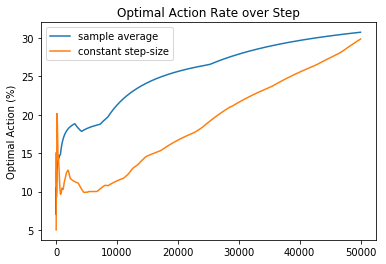

In [12]:
# greedy
plt.title('Optimal Action Rate over Step')
plt.ylabel('Steps')
plt.ylabel('Optimal Action (%)')
plt.plot(optimal_action_rate_sa['epsilon_0'], label='sample average')
plt.plot(optimal_action_rate_cs['epsilon_0'], label='constant step-size')
plt.legend()
plt.show()

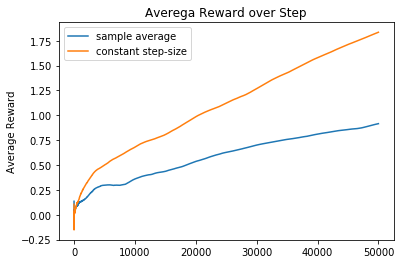

In [13]:
# greedy
plt.title('Averega Reward over Step')
plt.ylabel('Steps')
plt.ylabel('Average Reward')
plt.plot(average_reward_sa['epsilon_0'], label='sample average')
plt.plot(average_reward_cs['epsilon_0'], label='constant step-size')
plt.legend()
plt.show()

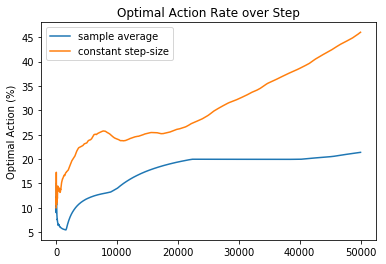

In [14]:
# epsilon=0.01
plt.title('Optimal Action Rate over Step')
plt.ylabel('Steps')
plt.ylabel('Optimal Action (%)')
plt.plot(optimal_action_rate_sa['epsilon_0.01'], label='sample average')
plt.plot(optimal_action_rate_cs['epsilon_0.01'], label='constant step-size')
plt.legend()
plt.show()

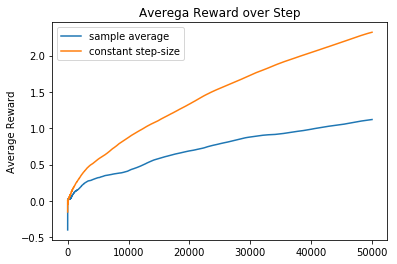

In [15]:
# epsilon=0.01
plt.title('Averega Reward over Step')
plt.ylabel('Steps')
plt.ylabel('Average Reward')
plt.plot(average_reward_sa['epsilon_0.01'], label='sample average')
plt.plot(average_reward_cs['epsilon_0.01'], label='constant step-size')
plt.legend()
plt.show()

### 以下の実験が一番Exerciseで指定されているシチュエーションに近い

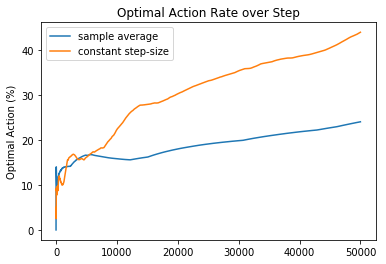

In [16]:
# epsilon=0.1
plt.title('Optimal Action Rate over Step')
plt.ylabel('Steps')
plt.ylabel('Optimal Action (%)')
plt.plot(optimal_action_rate_sa['epsilon_0.1'], label='sample average')
plt.plot(optimal_action_rate_cs['epsilon_0.1'], label='constant step-size')
plt.legend()
plt.show()

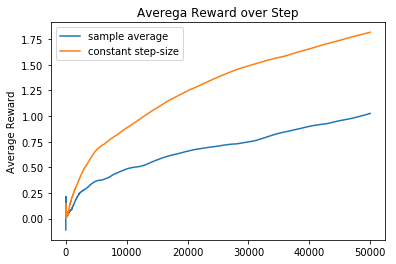

In [17]:
# epsilon=0.01
plt.title('Averega Reward over Step')
plt.ylabel('Steps')
plt.ylabel('Average Reward')
plt.plot(average_reward_sa['epsilon_0.1'], label='sample average')
plt.plot(average_reward_cs['epsilon_0.1'], label='constant step-size')
plt.legend()
plt.show()